# 1. Data Loading and Prep

## Connecting to Google BigQuery

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('User Authenticated')
project_id = 'causefinder'
%load_ext google.colab.data_table

User Authenticated


## Loading Cleaned and Feature Engineered Data where Bus is Late

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

rawDataLate = client.query('''SELECT * FROM `causefinder.TripDB.ProcessedTable` where (DelayStatus ='Late' or DelayStatus ='VeryLate')  ''').to_dataframe()

and (RouteId='44' or RouteId='47' or RouteId='42')

## Loading data to Dataframe

In [ ]:
from pandas import DataFrame
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

sns.set(style='white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)

Late_df=rawDataLate.copy(deep=True)
Late_df = Late_df.drop(['Hour','DelayStatus'],axis=1)
Late_df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,RouteId,DestinationId,StopId,VisitNumber,Latitude,Longitude,DayOfWeek,ArrivalDelayPrediction,DistanceInMeters,EncodedAddress,EncodedLocation,TimeOfDay,VehicleDirection,PredictedDelayStatus
0,44,7571,205,74,53.381411,-6.245341,4,8,21561.543081,323,926,3,1,4
1,44,7571,210,79,53.387527,-6.248318,4,13,22268.919642,41,888,5,1,5
2,44,7571,21,69,53.370092,-6.254291,4,15,20494.338417,11,472,3,1,5
3,44,7571,203,72,53.376396,-6.24993,3,10,21094.429006,323,908,3,1,4
4,44,7571,203,72,53.376396,-6.24993,3,7,21094.429006,323,908,2,1,4


## Heatmap showing correlation

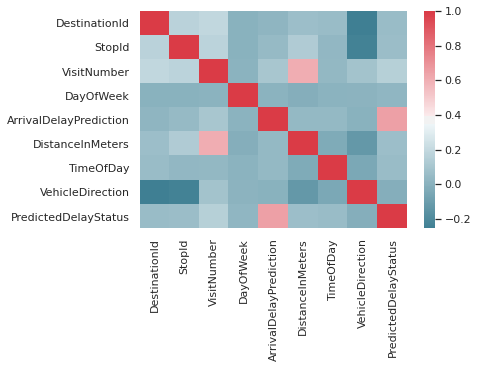

In [ ]:
sns.heatmap(Late_df.corr(),cmap=cmap)

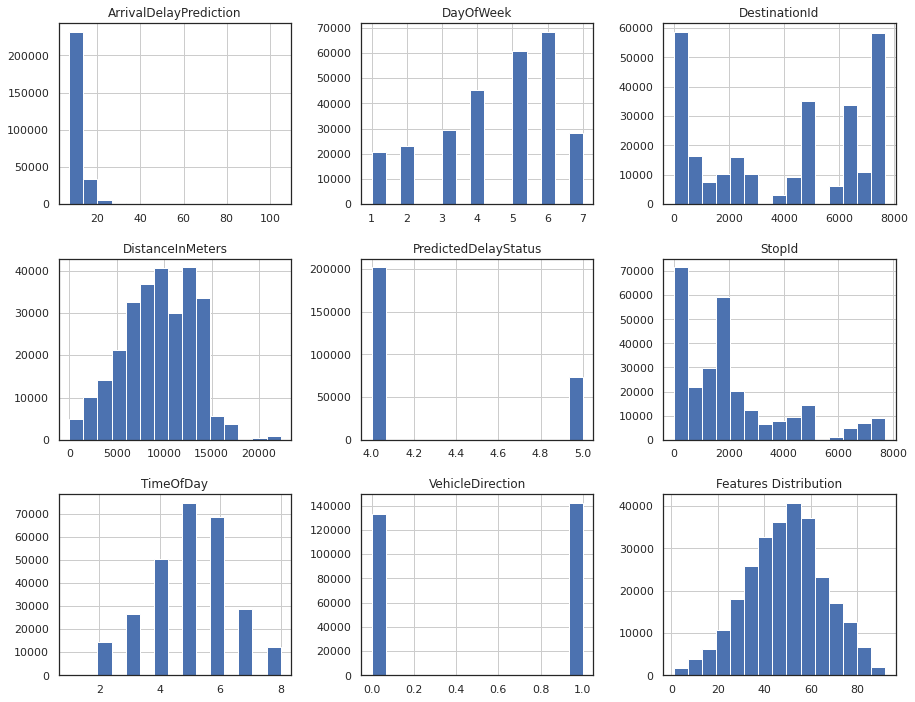

In [ ]:
Late_df.hist(figsize=(15,12),bins = 15)
plt.title("Features Distribution")
plt.show()

## Feature Engineering data for better clustering and reducing number of columns

In [ ]:
X=Late_df
# Import label encoder 
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 

X['RouteId']= label_encoder.fit_transform(X['RouteId']) 
Late_df['RouteId']= X['RouteId']
X['DestinationIdEncoded'] = label_encoder.fit_transform(X['DestinationId']) 

X['TripId'] = X['RouteId'].astype(str)+X['VehicleDirection'].astype(str)+X['DestinationIdEncoded'].astype(str)
X['Hour_Day'] = X['TimeOfDay'].astype(str)+X['DayOfWeek'].astype(str)

X.head()

,RouteId,DestinationId,StopId,VisitNumber,Latitude,Longitude,DayOfWeek,ArrivalDelayPrediction,DistanceInMeters,EncodedAddress,EncodedLocation,TimeOfDay,VehicleDirection,PredictedDelayStatus,DestinationIdEncoded,TripId,Hour_Day
0,11,7571,205,74,53.381411,-6.245341,4,8,21561.543081,323,926,3,1,4,49,11149,34
1,11,7571,210,79,53.387527,-6.248318,4,13,22268.919642,41,888,5,1,5,49,11149,54
2,11,7571,21,69,53.370092,-6.254291,4,15,20494.338417,11,472,3,1,5,49,11149,34
3,11,7571,203,72,53.376396,-6.24993,3,10,21094.429006,323,908,3,1,4,49,11149,33
4,11,7571,203,72,53.376396,-6.24993,3,7,21094.429006,323,908,2,1,4,49,11149,23


## Dropping Unnecessary columns and downcasting to improve performance

In [ ]:
X = X.drop(['RouteId','DestinationId','VehicleDirection','PredictedDelayStatus','DayOfWeek','Latitude','Longitude','EncodedLocation','StopId','DestinationIdEncoded','VisitNumber','EncodedAddress','TimeOfDay'],axis=1)

In [ ]:
def intDownCaster(col):
    return pd.to_numeric(X[col], downcast='integer')

for column in X:
    X[column]=intDownCaster(column)

print(X.dtypes)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


DistanceInMeters          float64
Hour_Day                     int8
ArrivalDelayPrediction       int8
VehicleDirection             int8
dtype: object


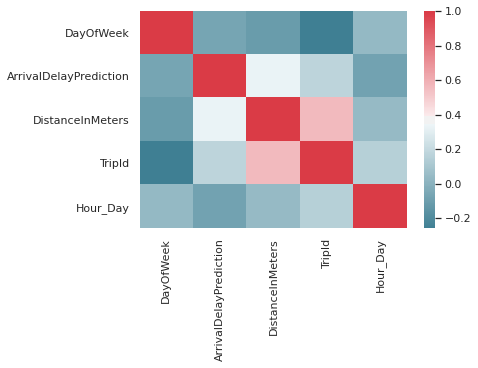

In [ ]:
sns.heatmap(X.corr(),cmap=cmap)

# 2. Clustering

## K-means Clustering

### Using Elbow method to find the optimum number of clusters

In [ ]:
from scipy.spatial import distance
from sklearn.cluster import KMeans
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,30) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    inertias.append(kmeanModel.inertia_) 

    mapping2[k] = kmeanModel.inertia_ 

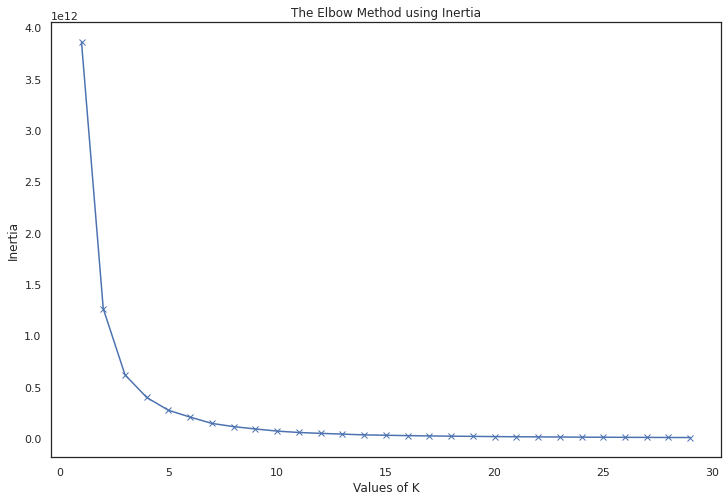

In [ ]:
plt.subplots(figsize=(12, 8))
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

### Clustering into 10 clusters

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(10).fit(X)
X['cluster'] = kmeans.predict(X)
Late_df['cluster']=X['cluster']
X['cluster'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


8    43749
0    43186
1    42563
3    37553
6    37314
9    26812
5    21259
2    13798
4     8151
7     1421
Name: cluster, dtype: int64

### Dimensionality Reduction using PCA to plot the clusters in a Scatterplot

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data = pd.DataFrame(pca.fit_transform(X))
# data = pd.DataFrame(data)
X['principal_feature1'] = data[0]
X['principal_feature2'] = data[1]
X.head()

,Latitude,Longitude,DayOfWeek,ArrivalDelayPrediction,DistanceInMeters,TimeOfDay,TripId,Hour_Day,cluster,principal_feature1,principal_feature2
0,53.381411,-6.245341,4,8,21561.543081,3,11149,34,6,-457.415946,12589.515962
1,53.387527,-6.248318,4,13,22268.919642,5,11149,54,6,-676.396389,13262.143077
2,53.370092,-6.254291,4,15,20494.338417,3,11149,34,6,-127.038744,11574.737321
3,53.376396,-6.249930,3,10,21094.429006,3,11149,33,6,-312.810478,12145.348644
4,53.376396,-6.249930,3,7,21094.429006,2,11149,23,6,-312.812401,12145.348697


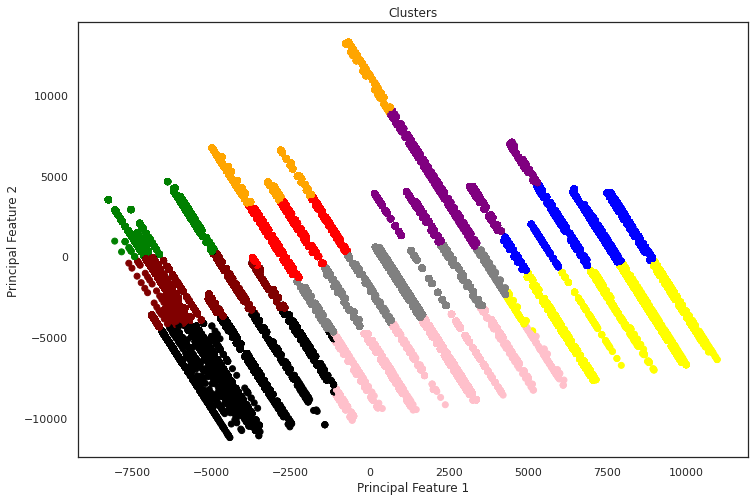

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = {0:'red', 1:'blue', 2:'green', 3:'pink',4:'purple',5:'black',6:'orange', 7:'yellow',8:'grey',9:'maroon',10:'indigo', 11:'violet',12:'crimson', 13:'teal',14:'seagreen', 15:'lightblue',16:'lightgreen', 17:'coral',18:'crimson'}
ax.scatter(X['principal_feature1'], X['principal_feature2'], c=X["cluster"].apply(lambda x: colors[x]))
ax.set_title('Clusters')
ax.set_xlabel('Principal Feature 1')
ax.set_ylabel('Principal Feature 2')
plt.show()

## DBScan Clustering

In [ ]:
datax = X.drop(['principal_feature1','principal_feature2','Latitude','Longitude','DayOfWeek','TimeOfDay'],axis=1)

In [ ]:
datax = X

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

datax = StandardScaler().fit_transform(datax)

# Compute DBSCAN
db = DBSCAN(eps=.5, min_samples=5).fit(datax)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(datax, labels))

Estimated number of clusters: 14
Estimated number of noise points: 44
Silhouette Coefficient: 0.305


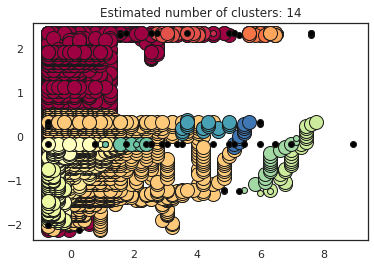

In [ ]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = datax[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = datax[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### OPTICS Algorithm

[-1 -1 -1 ...  2  2  2]


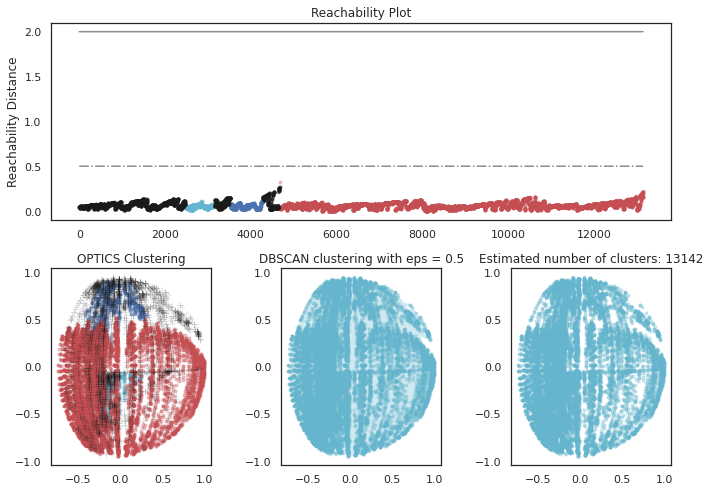

In [ ]:
from matplotlib import gridspec 
from sklearn.cluster import OPTICS, cluster_optics_dbscan 
from sklearn.preprocessing import normalize, StandardScaler 

# Scaling the data to bring all the attributes to a comparable level 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
  
# Normalizing the data so that the data 
# approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 
  
# Renaming the columns 
X_normalized.columns = X.columns 
  
X_normalized.head() 

# Building the OPTICS Clustering model 
optics_model = OPTICS(min_samples = 10, min_cluster_size = 0.05) 
  
# Training the model 
optics_model.fit(X_normalized) 

# Producing the labels according to the DBSCAN technique with eps = 0.5 
labels1 = cluster_optics_dbscan(reachability = optics_model.reachability_, 
                                   core_distances = optics_model.core_distances_, 
                                   ordering = optics_model.ordering_, eps = 0.5) 

# Producing the labels according to the DBSCAN technique with eps = 2.0 
labels2 = cluster_optics_dbscan(reachability = optics_model.reachability_, 
                                   core_distances = optics_model.core_distances_, 
                                   ordering = optics_model.ordering_, eps = 2) 
  
# Creating a numpy array with numbers at equal spaces till 
# the specified range 
space = np.arange(len(X_normalized)) 
  
# Storing the reachability distance of each point 
reachability = optics_model.reachability_[optics_model.ordering_] 
  
# Storing the cluster labels of each point 
labels = optics_model.labels_[optics_model.ordering_] 
  
print(labels) 

# Defining the framework of the visualization 
plt.figure(figsize =(10, 7)) 
plt.title('Estimated number of clusters: %d' % labels.size)
G = gridspec.GridSpec(2, 3) 
ax1 = plt.subplot(G[0, :]) 
ax2 = plt.subplot(G[1, 0]) 
ax3 = plt.subplot(G[1, 1]) 
ax4 = plt.subplot(G[1, 2]) 
  
# Plotting the Reachability-Distance Plot 
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
    Xk = space[labels == Class] 
    Rk = reachability[labels == Class] 
    ax1.plot(Xk, Rk, colour, alpha = 0.3) 
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha = 0.3) 
ax1.plot(space, np.full_like(space, 2., dtype = float), 'k-', alpha = 0.5) 
ax1.plot(space, np.full_like(space, 0.5, dtype = float), 'k-.', alpha = 0.5) 
ax1.set_ylabel('Reachability Distance') 
ax1.set_title('Reachability Plot') 
  
# Plotting the OPTICS Clustering 
colors = ['c.', 'b.', 'r.', 'y.', 'g.'] 
for Class, colour in zip(range(0, 5), colors): 
    Xk = X_normalized[optics_model.labels_ == Class] 
    ax2.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3) 
      
ax2.plot(X_normalized.iloc[optics_model.labels_ == -1, 0], 
        X_normalized.iloc[optics_model.labels_ == -1, 1], 
       'k+', alpha = 0.1) 
ax2.set_title('OPTICS Clustering') 
  
# Plotting the DBSCAN Clustering with eps = 0.5 
colors = ['c', 'b', 'r', 'y', 'g', 'greenyellow'] 
for Class, colour in zip(range(0, 6), colors): 
    Xk = X_normalized[labels1 == Class] 
    ax3.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3, marker ='.') 
        
ax3.plot(X_normalized.iloc[labels1 == -1, 0], 
        X_normalized.iloc[labels1 == -1, 1], 
       'k+', alpha = 0.1) 
ax3.set_title('DBSCAN clustering with eps = 0.5') 
  
# Plotting the DBSCAN Clustering with eps = 2.0 
colors = ['c.', 'y.', 'm.', 'g.'] 
for Class, colour in zip(range(0, 4), colors): 
    Xk = X_normalized.iloc[labels2 == Class] 
    ax4.plot(Xk.iloc[:, 0], Xk.iloc[:, 1], colour, alpha = 0.3) 
          
ax4.plot(X_normalized.iloc[labels2 == -1, 0], 
        X_normalized.iloc[labels2 == -1, 1], 
       'k+', alpha = 0.1) 
ax4.set_title('DBSCAN Clustering with eps = 2.0') 
  
plt.title('Estimated number of clusters: %d' % labels.size)
plt.tight_layout() 
plt.show() 

In [ ]:
from sklearn.cluster import AgglomerativeClustering 
import numpy as np 
  
clustering = AgglomerativeClustering(n_clusters = 2).fit(X) 
  
# print the class labels 
print(clustering.labels_.shape) 


(13142,)


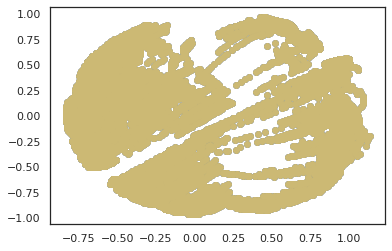

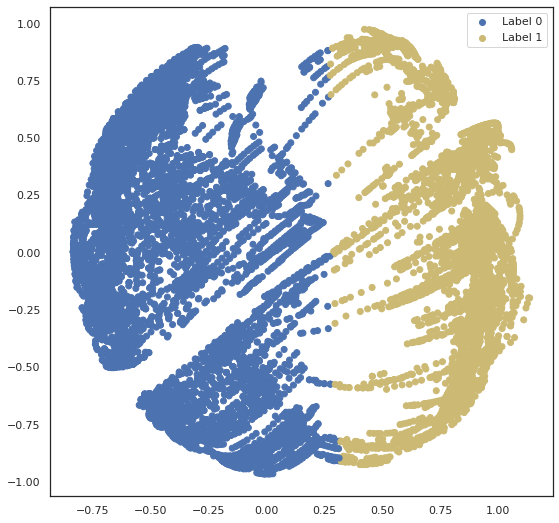

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.cluster import SpectralClustering 
from sklearn.preprocessing import StandardScaler, normalize 
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score 

# Preprocessing the data to make it visualizable 
  
# Scaling the Data 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 
  
# Normalizing the Data 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
  
X_principal.head() 

# Building the clustering model 
spectral_model_rbf = SpectralClustering(n_clusters = 2, affinity ='rbf') 
  
# Training the model and Storing the predicted cluster labels 
labels_rbf = spectral_model_rbf.fit_predict(X_principal) 

# Building the label to colour mapping 
colours = {} 
colours[0] = 'b'
colours[1] = 'y'
  
# Building the colour vector for each data point 
cvec = [colours[label] for label in labels_rbf] 
  
# Plotting the clustered scatter plot 
  
b = plt.scatter(X_principal['P1'], X_principal['P2'], color ='b'); 
y = plt.scatter(X_principal['P1'], X_principal['P2'], color ='y'); 
  
plt.figure(figsize =(9, 9)) 
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec) 
plt.legend((b, y), ('Label 0', 'Label 1')) 
plt.show() 

In [ ]:
# Building the clustering model 
spectral_model_nn = SpectralClustering(n_clusters = 2, affinity ='nearest_neighbors') 
  
# Training the model and Storing the predicted cluster labels 
labels_nn = spectral_model_nn.fit_predict(X_principal) 


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [ ]:
# List of different values of affinity 
affinity = ['rbf', 'nearest-neighbours'] 
  
# List of Silhouette Scores 
s_scores = [] 
  
# Evaluating the performance 
s_scores.append(silhouette_score(X, labels_rbf)) 
s_scores.append(silhouette_score(X, labels_nn)) 
  
print(s_scores) 

[0.29774985243657165, -0.3297981056612948]


In [ ]:
# from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

kmeans_silhouette = silhouette_score(
     dataz, kmeans.labels_
).round(2)
dbscan_silhouette = silhouette_score(
    datax, db.labels_
).round(2)
optics_silhouette = silhouette_score(
    datay, clust.labels_
).round(2)


print('KMeans silhouette :',kmeans_silhouette)
print('DBScan silhouette :',dbscan_silhouette)
print('Optics silhouette :',optics_silhouette)

KMeans silhouette : 0.44
DBScan silhouette : 0.04
Optics silhouette : 0.13


# 3. Classification

## Splitting into Training and Testing Sets

In [ ]:
y = Late_df[['cluster']]

In [ ]:
X = Late_df[['DistanceInMeters','Hour_Day','ArrivalDelayPrediction','VehicleDirection',]]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
random.seed(0)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

## Applying Classification Models

### Logistic Regression

In [ ]:
from sklearn import linear_model
from sklearn import metrics
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='sag',max_iter = 4000).fit(train_x, train_y.values.ravel())
y_pred=mul_lr.predict(test_x)
print ("Accuracy :: ", metrics.accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred, digits=3))

Accuracy ::  0.3212175048040318
              precision    recall  f1-score   support

           0      0.239     0.019     0.035      5460
           1      0.259     0.379     0.308      8095
           2      0.260     0.564     0.356      6070
           3      0.499     0.512     0.505      3726
           4      0.280     0.126     0.174      5366
           5      0.306     0.014     0.027      3454
           6      0.310     0.308     0.309      4141
           7      0.328     0.291     0.308      3839
           8      0.392     0.635     0.485      9086
           9      0.307     0.056     0.094      5925

    accuracy                          0.321     55162
   macro avg      0.318     0.290     0.260     55162
weighted avg      0.314     0.321     0.275     55162



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Decision Tree Classifier

In [ ]:
# training a DescisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier(max_depth = 10, criterion = 'entropy').fit(train_x, train_y.values.ravel()) 
y_pred = dtree_model.predict(test_x)   

print ("Accuracy :: ", metrics.accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred, digits=3))

Accuracy ::  0.7014974076356912
              precision    recall  f1-score   support

           0      0.726     0.581     0.646      8095
           1      0.816     0.582     0.679      5433
           2      0.750     0.799     0.774      5366
           3      0.895     0.880     0.887      4141
           4      0.821     0.831     0.826      6071
           5      0.593     0.621     0.607      5932
           6      0.593     0.599     0.596      3838
           7      0.622     0.857     0.721      9051
           8      0.785     0.378     0.510      3443
           9      0.605     0.741     0.666      3792

    accuracy                          0.701     55162
   macro avg      0.721     0.687     0.691     55162
weighted avg      0.715     0.701     0.697     55162



In [ ]:
# training a RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(max_depth = 10).fit(train_x, train_y.values.ravel()) 
y_pred = rf.predict(test_x) 
  

print ("Accuracy :: ", metrics.accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred, digits=3))

Accuracy ::  0.6366339146513904
              precision    recall  f1-score   support

           0      0.875     0.425     0.572      5460
           1      0.582     0.579     0.581      8095
           2      0.721     0.785     0.752      6070
           3      0.605     0.762     0.675      3726
           4      0.669     0.609     0.638      5366
           5      0.709     0.211     0.325      3454
           6      0.802     0.829     0.815      4141
           7      0.611     0.555     0.582      3839
           8      0.571     0.835     0.678      9086
           9      0.543     0.567     0.555      5925

    accuracy                          0.637     55162
   macro avg      0.669     0.616     0.617     55162
weighted avg      0.657     0.637     0.625     55162



### XG Boost Classifier

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best: -0.000026 using {'learning_rate': 0.3}
-2.253812 (0.000000) with: {'learning_rate': 0.0001}
-1.897962 (0.000000) with: {'learning_rate': 0.001}
-0.604886 (0.000000) with: {'learning_rate': 0.01}
-0.000093 (0.000000) with: {'learning_rate': 0.1}
-0.000026 (0.000000) with: {'learning_rate': 0.2}
-0.000026 (0.000000) with: {'learning_rate': 0.3}


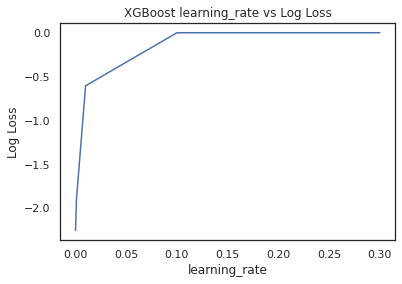

In [ ]:
from matplotlib import pyplot
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
model = xgb.XGBClassifier(max_depth=10,objective="multi:softmax")

learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(train_x, train_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

# plot
pyplot.errorbar(learning_rate, means, yerr=stds)
pyplot.title("XGBoost learning_rate vs Log Loss")
pyplot.xlabel('learning_rate')
pyplot.ylabel('Log Loss')
pyplot.savefig('learning_rate.png')

In [ ]:
import xgboost as xgb
gbm_all = xgb.XGBClassifier(max_depth=10,objective="multi:softmax",learning_rate=0.1,num_class=10)
fit_model = gbm_all.fit(train_x, train_y.values.ravel())
y_pred=gbm_all.predict(test_x)
print ("Accuracy :: ", metrics.accuracy_score(test_y,y_pred))
print(metrics.classification_report(test_y, y_pred, digits=3))

Accuracy ::  0.9708676262644574
              precision    recall  f1-score   support

           0      0.956     0.959     0.958      8095
           1      0.997     0.975     0.986      5433
           2      0.991     0.989     0.990      5366
           3      0.996     1.000     0.998      4141
           4      0.997     0.998     0.997      6071
           5      0.969     0.948     0.959      5932
           6      0.931     0.946     0.938      3838
           7      0.967     0.992     0.979      9051
           8      0.964     0.882     0.921      3443
           9      0.930     0.981     0.954      3792

    accuracy                          0.971     55162
   macro avg      0.970     0.967     0.968     55162
weighted avg      0.971     0.971     0.971     55162



### Classifier using Deep Learning (Fastai)

In [ ]:
X = Late_df[['StopId','DayOfWeek','DistanceInMeters','TimeOfDay','VehicleDirection','VisitNumber','cluster']]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
random.seed(0)
train, test = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
from fastai.tabular import *
dep_var = 'cluster'
cont_names = ['StopId','DayOfWeek','DistanceInMeters','TimeOfDay','VehicleDirection','VisitNumber']

test_id=test[['cluster']]
test = TabularList.from_df(test, cont_names=cont_names)


data = (TabularList.from_df(train, path='.', cont_names=cont_names)
                        .split_by_idx(list(range(0,200)))
                        .label_from_df(cols = dep_var)
                        .add_test(test, label=0)
                        .databunch())

data.show_batch(rows=10)

StopId,DayOfWeek,DistanceInMeters,TimeOfDay,VehicleDirection,VisitNumber,target
272.0000,7.0000,2901.5791,8.0000,1.0000,17.0000,7
4509.0000,5.0000,6483.5610,4.0000,0.0000,34.0000,7
204.0000,4.0000,3438.8647,7.0000,0.0000,15.0000,4
1456.0000,7.0000,6563.8838,4.0000,1.0000,34.0000,7
7025.0000,5.0000,11761.7705,3.0000,0.0000,48.0000,8
3585.0000,3.0000,12895.3125,3.0000,0.0000,48.0000,9
18.0000,2.0000,13549.7822,5.0000,1.0000,60.0000,5
264.0000,5.0000,2362.9414,5.0000,0.0000,13.0000,6
2455.0000,5.0000,10400.7246,5.0000,0.0000,62.0000,3
4432.0000,1.0000,9641.8779,7.0000,1.0000,44.0000,2


epoch,train_loss,valid_loss,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.849804,0.713406,0.780000,0.772246,0.750671,01:28
1,0.703425,0.512845,0.835000,0.811901,0.811489,01:28
2,0.633198,0.451523,0.800000,0.794825,0.769230,01:28
3,0.594955,0.382896,0.860000,0.843097,0.828830,01:28
4,0.532375,0.345171,0.890000,0.869571,0.884171,01:29
5,0.503916,0.355692,0.875000,0.868419,0.864412,01:28
6,0.486256,0.311422,0.885000,0.869878,0.853453,01:28
7,0.432601,0.348406,0.840000,0.837876,0.825413,01:27
8,0.434862,0.293674,0.890000,0.869660,0.873504,01:29
9,0.413946,0.251988,0.905000,0.895435,0.895276,01:28


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


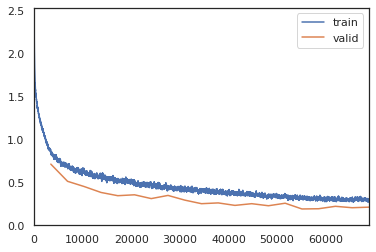

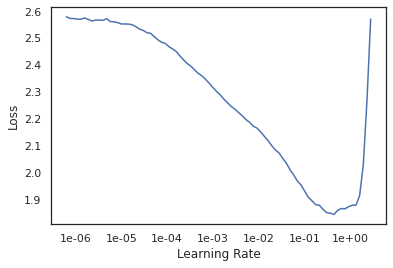

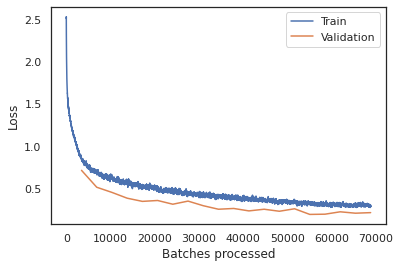

In [ ]:
precision=Precision()
recall=Recall()
# Create deep learning model
learn = tabular_learner(data, layers=[1000, 200, 15], metrics=[accuracy,precision,recall], emb_drop=0.1, callback_fns=ShowGraph)

# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
learn.recorder.plot()

# Fit the model based on selected learning rate
learn.fit_one_cycle(20, max_lr=slice(1e-03))

# Analyse our model
learn.model
learn.recorder.plot_losses()

In [ ]:
from sklearn import metrics
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

actuals = test_id
print(metrics.classification_report(y_pred=labels, y_true=actuals))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      6769
           1       0.95      0.94      0.95      8583
           2       0.84      0.91      0.87      5290
           3       0.95      0.94      0.95      8198
           4       0.93      0.90      0.91      3992
           5       0.97      0.93      0.95      6113
           6       0.91      0.86      0.88      3831
           7       0.84      0.86      0.85      3406
           8       0.89      0.84      0.87      3544
           9       0.95      0.98      0.96      5436

    accuracy                           0.92     55162
   macro avg       0.92      0.91      0.92     55162
weighted avg       0.93      0.92      0.93     55162



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
# from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
import xgboost as xgb

random.seed(0)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

models = [KNeighborsClassifier(n_neighbors = 10), 
          GaussianNB(),
          DecisionTreeClassifier(max_depth = 10),
          RandomForestClassifier(max_depth = 10),
          xgb.XGBClassifier(max_depth=10,objective="multi:softmax",learning_rate=0.1),
          LogisticRegression(multi_class='multinomial', solver='sag',max_iter = 4000)]
          # svm.SVC(kernel='linear', C = 1.0)]

model_names = ['KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest Classifier', 'Random Forest Regressor','XG Boost Classifier','LogisticRegression']

accuracy = []
precision_delay = []
recall_delay = []
f1_delay = []

## Go through the models and find the scores
for model in models:
    model.fit(train_x, train_y.values.ravel())
    y_hat = model.predict(test_x)
    
    accuracy.append( accuracy_score(test_y, y_hat) )
    precision_delay.append( precision_score(test_y, y_hat, pos_label=1,average='macro') )
    recall_delay.append( recall_score(test_y, y_hat, pos_label=1,average='macro'))
    f1_delay.append( f1_score(test_y, y_hat, pos_label=1,average='macro') )

accuracy_df = pd.DataFrame({'accuracy':accuracy, 'precision-delay':precision_delay,
                            'recall-delay':recall_delay, 'f1-delay':f1_delay})

model_names_x = ['KNN', 'Naive Bayes', 'Decision Tree', 'Random Forest','XG Boost Classifier','Logistic Regression']
accuracy_df.set_index([model_names_x])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision-delay,recall-delay,f1-delay
KNN,0.910446,0.909526,0.900825,0.904111
Naive Bayes,0.489812,0.460569,0.455582,0.441755
Decision Tree,0.689351,0.701230,0.663110,0.668768
Random Forest,0.637432,0.661085,0.614451,0.616725
XG Boost Classifier,0.971847,0.972874,0.970022,0.971159
Logistic Regression,0.328723,0.289061,0.295884,0.273636
